In [1]:
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
from datetime import datetime 

In [2]:
with open('./data/user2movie.json', 'rb') as f:
    user2movie = pickle.load(f)

with open('./data/movie2user.json', 'rb') as f: 
    movie2user = pickle.load(f)

with open('./data/usermovie2rating.json', 'rb') as f: 
    usermovie2rating = pickle.load(f)

with open('./data/usermovie2rating_test.json', 'rb') as f: 
    usermovie2rating_test = pickle.load(f)

In [3]:
N = np.max(list(user2movie.keys())) + 1

m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
N, M # users, movies

(10000, 2000)

In [4]:
K = 10 # latent dimensionality 
W = np.random.randn(N, K) 
b = np.zeros(N) 
U = np.random.randn(M, K) 
c = np.zeros(M) 
mu = np.mean(list(usermovie2rating.values()))

In [6]:
def get_loss(d):
    # d : (user_id, movie_id) -> rating 
    N = float(len(d))
    sse = 0 
    for k, r in d.items(): 
        i, j = k 
        p = W[i].dot(U[j]) + b[i] + c[j] + mu 
        sse += (p-r) * (p-r)
    return sse / N

epoch: 0
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:00:20.733395
j: 0 M 2000
j: 200 M 2000
j: 400 M 2000
j: 600 M 2000
j: 800 M 2000
j: 1000 M 2000
j: 1200 M 2000
j: 1400 M 2000
j: 1600 M 2000
j: 1800 M 2000
updated U and c: 0:00:20.684028
epoch duration: 0:00:41.417609
calculate cost: 0:00:03.858654
train loss: 0.7201287000104389
test loss: 0.7563071697900158
epoch: 1
i: 0 N: 10000
i: 1000 N: 10000
i: 2000 N: 10000
i: 3000 N: 10000
i: 4000 N: 10000
i: 5000 N: 10000
i: 6000 N: 10000
i: 7000 N: 10000
i: 8000 N: 10000
i: 9000 N: 10000
updated W and b: 0:00:19.994347
j: 0 M 2000
j: 200 M 2000
j: 400 M 2000
j: 600 M 2000
j: 800 M 2000
j: 1000 M 2000
j: 1200 M 2000
j: 1400 M 2000
j: 1600 M 2000
j: 1800 M 2000
updated U and c: 0:00:19.830107
epoch duration: 0:00:39.824653
calculate cost: 0:00:03.848866
train loss: 0.5676981624388376
test loss: 0.60724

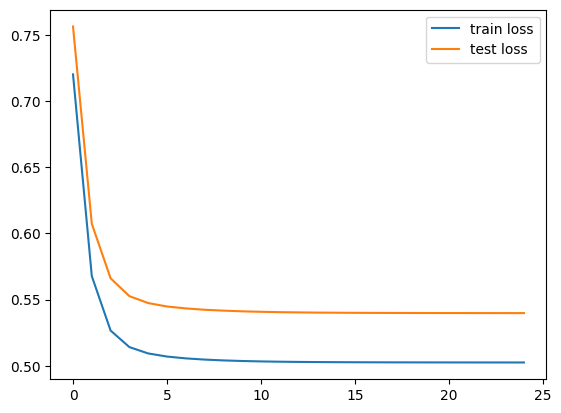

In [7]:
# train the parameters 
epochs = 25
reg = 0.01 # regularization penalty 
train_losses = []
test_losses = []

for epoch in range(epochs): 
    print("epoch:", epoch)
    epoch_start = datetime.now()

    # perform updates 
    # update W and b 
    t0 = datetime.now() 
    for i in range(N): 
        # for W 
        matrix = np.eye(K) * reg 
        vector = np.zeros(K) 

        # for b 
        bi = 0 
        for j in user2movie[i]: 
            r = usermovie2rating[(i, j)]
            matrix += np.outer(U[j], U[j])
            vector += (r - b[i] - c[j] - mu)* U[j]
            bi += (r - W[i].dot(U[j]) - c[j] - mu)

        
        # set the updates 
        W[i] = np.linalg.solve(matrix, vector) 
        b[i] = bi / ((1 + reg) * len(user2movie[i]))

        if i % (N//10) == 0: 
            print("i:", i, "N:", N)
    print("updated W and b:", datetime.now() - t0) 

    # update U and c 
    t0 = datetime.now() 
    for j in range(M): 
        # for U 
        matrix = np.eye(K) * reg 
        vector = np.zeros(K) 

        # for c 
        cj = 0 
        try: 
            for i in movie2user[j]: 
                r = usermovie2rating[(i, j)]
                matrix += np.outer(W[i], W[i])
                vector += (r - b[i] - c[j] - mu) * W[i]
                cj += (r-W[i].dot(U[j]) - b[i] - mu)
            
            # set the updates 
            U[j] = np.linalg.solve(matrix, vector) 
            c[j] = cj / ((1+reg) * len(movie2user[j])) 

            if j % (M//10) == 0: 
                print("j:", j, "M", M) 

        except KeyError: 
            # possible not to have and ratings for a movie 
            pass 
    print("updated U and c:", datetime.now() - t0) 
    print("epoch duration:", datetime.now() - epoch_start)

    t0 = datetime.now() 
    train_losses.append(get_loss(usermovie2rating))

    # store test loss 
    test_losses.append(get_loss(usermovie2rating_test))
    print("calculate cost:", datetime.now() - t0) 
    print("train loss:", train_losses[-1])
    print("test loss:", test_losses[-1])

print("train losses:", train_losses) 
print("test losses:", test_losses) 

# plot losses 
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend() 
plt.show() 
